# P09: Analyzing Monte Carlo Markov Chains 

In the last problem sheet, we wrote our own Metropolis-Hastings sampler and applied it to the SNLS SNe Ia likelihood. In this problem set, we will analyze the generated MCMC, and in particular we will investigate its convergence.

To this end, we will sample the SNLS likelihood using the intial condition generator and proposal covariance matrix as given below:

In [63]:
import numpy as np
from sympy import *
from scipy.stats import linregress as linres

In [64]:
def initGen(init0 = np.array([0.2, 1.5, 2.0, 24.5]), sig = np.array([0.03, 0.1, 0.1, 0.02]), n=4):
    return np.random.randn(n) * sig + init0

In [65]:
proposal_cov = np.array([[ 0.003, -0.004, -0.005,  0.002],
                   [-0.004,  0.036,  0.011, -0.002],
                   [-0.005,  0.011,  0.061, -0.003],
                   [ 0.002, -0.002, -0.003,  0.002]])

## Problem 1: Visualization

Use your implementation of the Metropolis-Hastings sample to generate 500 samples from the SNLS posterior, starting around an initial position as generated by the intial condition generator given above and with proposal covariance as given by `proposal_cov`.

(i) Plot the trace plots for all 4 parameters $\Omega_m, \alpha, \beta, M$ and estimate the burn-in.

(ii) Does the scatter of the burn-in removed chains around their mean agree with your expectations? Why? Why not?

(iii) Estimate the acceptance fraction of the burn-in-removed chain.

(iv) Plot the 2D contours for the burn-in-removed chains using [`corner`](https://corner.readthedocs.io/en/latest/) (or your contour plotting tool of choice).

## Solution 1:

In [66]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

From lecture notes

In [67]:
mu = np.array([0.2, 1.5, 2.0, 24.5])
sig = np.array([0.03, 0.1, 0.1, 0.02])

C = np.array([[ 0.003, 0.004, 0.005,  0.002], [0.004,  0.036,  0.011, 0.002], [0.005,  0.011,  0.061, 0.003],[ 0.002, 0.002, 0.003,  0.002]])
Cinv = np.linalg.inv(C)

class multnormal(object):
    
    def __init__(self):
        pass
    
    def getLogLikelihood(self, x):
        """
        Likelihood function.
        Args:
        x (:obj:`integer`, `float` or `array`): parameter value

        Returns:
            loglike (:obj:`integer`, `float` or `array`): log likelihood values of x
        """
        
        delta = x - mu
        loglike = -np.dot(np.dot(delta, Cinv), delta)/2.
        
        return loglike

In [68]:
def MHsampler(loglike, init, cov, n):
    """
    Metropolis Hastings sampler.
    Args:
    loglike (:class: ): likelihood module with function getLogLikelihood
    init (:obj:`integer`, `float` or `array`): initial position of the chain
    cov (:obj:`integer` or `float` or `array`): covariance matrix of the proposal
    n (:obj:`integer`): number of iterations
    
    Returns:
        chain (:obj:`integer`, `float` or `array`): sampled mcmc parameter values
        likes (:obj:`integer`, `float` or `array`): likelihood values of mcmc
    """
    try:
        d = len(init)
    except:
        d = 1
    chain = np.zeros((n, d))
    likes = np.zeros(n)
    p = init
    ll = loglike.getLogLikelihood(p)
    counter = []
    for i in range(n):
        if d > 1:
            pn = np.random.multivariate_normal(p, cov)
        else:
            pn = np.random.normal(p, cov)        
        lln = loglike.getLogLikelihood(pn)
        r = np.random.rand()
        if lln-ll > np.log(r):
            p = pn
            ll = lln
            counter.append(1)
        else:
            counter.append(0)
        chain[i] = p
        likes[i] = ll
        
    return chain, likes, counter

In [69]:
like = multnormal()

In [92]:
init = initGen(init0 =np.array([0.2, 1.5, 2.0, 24.5]), n=1)
chain, likes, counter = MHsampler(like, init, proposal_cov, 10000)

### (i)

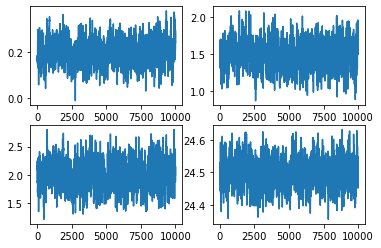

In [93]:
plt.figure()
iteration = np.arange(0, len(chain),1)
plt.subplot(221)
plt.plot(iteration, chain[:,0], label = 'omega_m')
plt.subplot(222)
plt.plot(iteration, chain[:,1], label = 'alpha')
plt.subplot(223)
plt.plot(iteration, chain[:,2], label = 'beta')
plt.subplot(224)
plt.plot(iteration, chain[:,3], label = 'M')

The burn in depends on the inital parameters. With the one given in initGen, the convergence is within 100 iterations

## (ii)

In [94]:
chain_new = chain[500:]
chain_mean = np.mean(chain_new, axis = 0)
std = np.std(chain_new, axis = 0, ddof = 1)

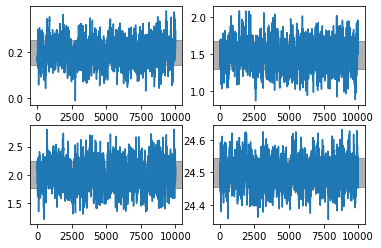

In [95]:
plt.figure()
iteration = np.arange(0, len(chain),1)
plt.subplot(221)
plt.plot(iteration, chain[:,0], label = 'omega_m')
plt.axhspan(chain_mean[0]-std[0], chain_mean[0]+std[0], color='k', alpha=0.3, zorder=-1)
plt.subplot(222)
plt.plot(iteration, chain[:,1], label = 'alpha')
plt.axhspan(chain_mean[1]-std[1], chain_mean[1]+std[1], color='k', alpha=0.3, zorder=-1)
plt.subplot(223)
plt.plot(iteration, chain[:,2], label = 'beta')
plt.axhspan(chain_mean[2]-std[2], chain_mean[2]+std[2], color='k', alpha=0.3, zorder=-1)
plt.subplot(224)
plt.plot(iteration, chain[:,3], label = 'M')
plt.axhspan(chain_mean[3]-std[3], chain_mean[3]+std[3], color='k', alpha=0.3, zorder=-1)

### (iii)

In [96]:
np.sum(counter[:])/len(chain[:])

0.3274

In [97]:
acc_frac = np.sum(counter[500:])/len(chain[500:])

In [98]:
acc_frac

0.3290526315789474

### (iv)

In [80]:
import corner

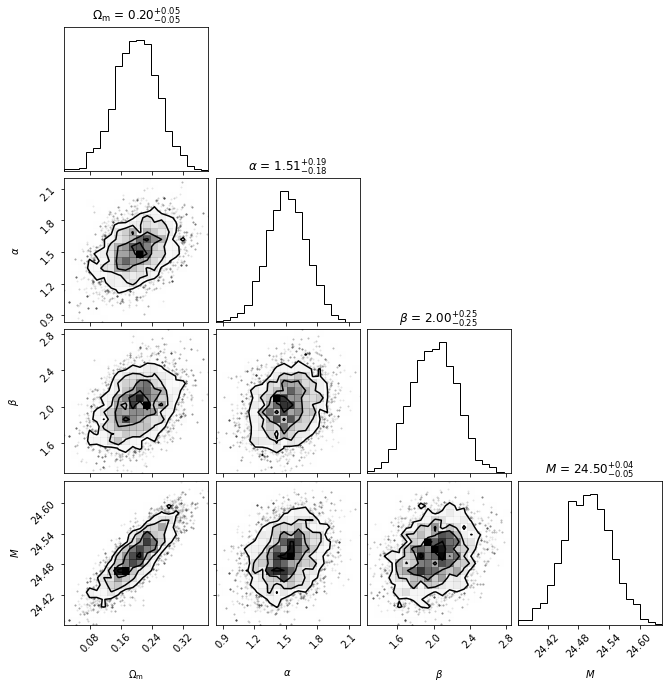

In [81]:
figure = corner.corner(np.array(chain_new),labels=[r'$\Omega_\mathrm{m}$', r'$\alpha$', r'$\beta$', r'$M$'], show_titles=True,)

## Problem 2: Autocorrelation function

(i) Create 1500 samples from the SNLS posterior, cut-off the burn-in, and estimate the autocorrelation function $\rho_{ff}(T)$ for $T \leq 50$ for all 4 parameters $\Omega_m, \alpha, \beta, M$. Plot your results.

(ii) Estimate $\tau_{ff}$ by determining the best-fit value such that $\hat{\rho}_{ff}(T)=e^{-T/\tau_{ff}}$. Note that you can use linear regression if you reparametrize the problem accordingly.

(iii) Discuss your results.

## Solution 2:

### (i)

In [55]:
init = initGen(init0 =np.array([0.2, 1.5, 2.0, 24.5]))
chain, likes, counter = MHsampler(like, init, proposal_cov, 1500)

In [56]:
chain_new = chain[500:]
chain_mean = np.mean(chain_new, axis = 0)
std = np.array([0.03, 0.1, 0.1, 0.02])

In [60]:
i = 0
n = len(chain_new[:,i])
# T = 50
chain_new_0 = chain_new[:,0]

C_ff_T_list = []
for T in range(0,25):
    C_ff_T = (1/(n-T)) * np.sum((chain_new[0:n-T,:] - np.mean(chain_new, axis = 0))* (chain_new[T:n,:] - np.mean(chain_new, axis = 0)), axis = 0)
    C_ff_T_list.append(C_ff_T)
C_ff_T_list = np.array(C_ff_T_list)

### (ii)

Text(0.5, 0.98, 'Log Plots')

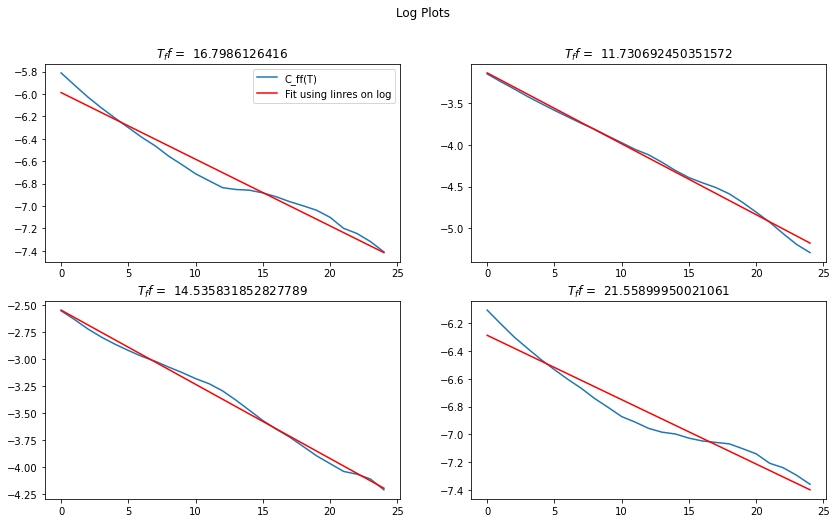

In [61]:
plt.figure(figsize = (14,8))
plt.subplot(221)
plt.plot(np.log(C_ff_T_list[:,0]), label = 'C_ff(T)')
x = np.arange(0,len(C_ff_T_list),1)
ls0 = linres(x, np.array(np.log(C_ff_T_list[:,0])))
y = (ls0.slope * x) + ls0.intercept
plt.plot(y, c ='r', label = 'Fit using linres on log')
plt.title(f'$T_ff$ =  {(-1)/ls0.slope}')
plt.legend()

plt.subplot(222)
plt.plot(np.log(C_ff_T_list[:,1]))

ls1 = linres(x, np.array(np.log(C_ff_T_list[:,1])))
y = (ls1.slope * x) + ls1.intercept
plt.plot(y, c ='r')
plt.title(f'$T_ff$ =  {(-1)/ls1.slope}')

plt.subplot(223)
plt.plot(np.log(C_ff_T_list[:,2]))

ls2 = linres(x, np.array(np.log(C_ff_T_list[:,2])))
y = (ls2.slope * x) + ls2.intercept
plt.plot(y, c ='r')
plt.title(f'$T_ff$ =  {(-1)/ls2.slope}')

plt.subplot(224)
plt.plot(np.log(C_ff_T_list[:,3]))

ls3 = linres(x, np.array(np.log(C_ff_T_list[:,3])))
y = (ls3.slope * x) + ls3.intercept
plt.plot(y, c ='r')
plt.title(f'$T_ff$ =  {(-1)/ls3.slope}')
plt.suptitle('Log Plots')
# plt.supylabel('C_ff(T)')

Text(0.5, 0.98, 'Non log plots')

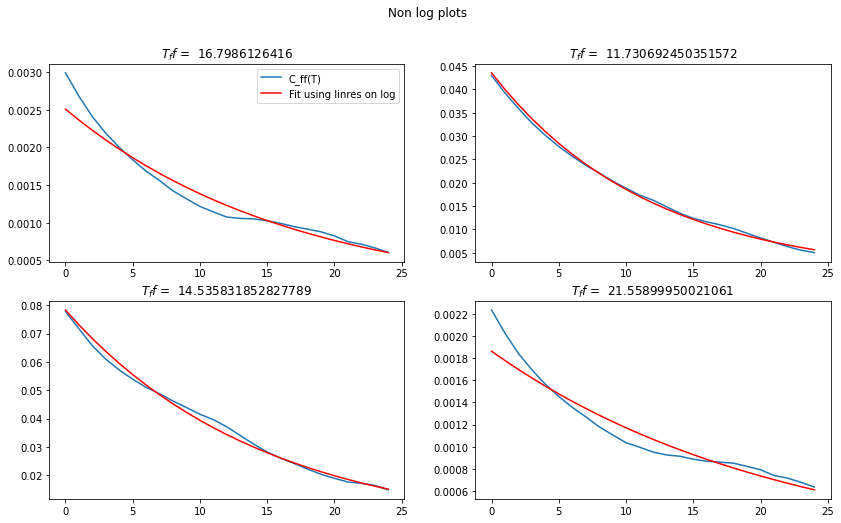

In [62]:
plt.figure(figsize = (14,8))
plt.subplot(221)
plt.plot((C_ff_T_list[:,0]), label = 'C_ff(T)')
x = np.arange(0,len(C_ff_T_list),1)
ls0 = linres(x, np.array(np.log(C_ff_T_list[:,0])))
y = (ls0.slope * x) + ls0.intercept
plt.plot(np.exp(y), c ='r', label = 'Fit using linres on log')
plt.title(f'$T_ff$ =  {(-1)/ls0.slope}')
plt.legend() 

plt.subplot(222)
plt.plot((C_ff_T_list[:,1]))
ls1 = linres(x, np.array(np.log(C_ff_T_list[:,1])))
y = (ls1.slope * x) + ls1.intercept
plt.plot(np.exp(y), c ='r')
plt.title(f'$T_ff$ =  {(-1)/ls1.slope}')

plt.subplot(223)
plt.plot((C_ff_T_list[:,2]))
ls2 = linres(x, np.array(np.log(C_ff_T_list[:,2])))
y = (ls2.slope * x) + ls2.intercept
plt.plot(np.exp(y), c ='r')
plt.title(f'$T_ff$ =  {(-1)/ls2.slope}')

plt.subplot(224)
plt.plot((C_ff_T_list[:,3]))
ls3 = linres(x, np.array(np.log(C_ff_T_list[:,3])))
y = (ls3.slope * x) + ls3.intercept
plt.plot(np.exp(y), c ='r')
plt.title(f'$T_ff$ =  {(-1)/ls3.slope}')
plt.suptitle('Non log plots')

(iii)

There's very small correlation even for a small lag. 
Different parameters have different autocorrelation time (T_ff).

## Problem 3: MCMC errors

(i) Use your estimate of $\tau_{ff}$ to estimate the errors on the mean of the posterior as estimated from the sample for each model parameter. 

(ii) Confirm your results by repeated sampling of the SNLS posterior.

have## Solution 3

In [33]:
T_ff_0 = -1/ls0.slope
err_mean_0 = (2 * T_ff_0 / n) * np.std(chain_new[:,0])

T_ff_1 = -1/ls1.slope
err_mean_1 = (2 * T_ff_1 / n) * np.std(chain_new[:,1])

T_ff_2 = -1/ls2.slope
err_mean_2 = (2 * T_ff_2 / n) * np.std(chain_new[:,2])

T_ff_3 = -1/ls3.slope
err_mean_3 = (2 * T_ff_3 / n) * np.std(chain_new[:,3])


In [34]:
print(err_mean_0)
print(err_mean_1)
print(err_mean_2)
print(err_mean_3)

0.00237167069888936
0.003996072724180612
0.009772374101805596
0.0010256602427014387


In [35]:
# init_1 = initGen(init0 =np.array([0.2, 1.5, 2.0, 24.5]))
# chain_1, likes_1, counter_1 = MHsampler(like, init, proposal_cov, 1500)

# init_2 = initGen(init0 =np.array([0.2, 1.5, 2.0, 24.5]))
# chain_2, likes_2, counter_2 = MHsampler(like, init, proposal_cov, 1500)

# init_3 = initGen(init0 =np.array([0.2, 1.5, 2.0, 24.5]))
# chain_3, likes_3, counter_3 = MHsampler(like, init, proposal_cov, 1500)

Repeat and plot and see if the std and the error on mean agree

## Problem 4: Gelman-Rubin convergence test

(i) Use the samples generated in problem 3 to compute the Gelman-Rubin statistic $R$. 

(ii) What does your result suggest about the chain convergence?

(iii) Do your results depend on the number of chains you consider?

## Solution 4

In [36]:
n = 1500
m = 3 # number of chains

In [37]:
init_1 = initGen(init0 =np.array([0.2, 1.5, 2.0, 24.5]))
chain_1, likes_1, counter_1 = MHsampler(like, init, proposal_cov, n)

init_2 = initGen(init0 =np.array([0.3, 4.2, 4.0, 40]))
chain_2, likes_2, counter_2 = MHsampler(like, init, proposal_cov, n)

init_3 = initGen(init0 =np.array([0.1, 0.1, 1.0, 1]))
chain_3, likes_3, counter_3 = MHsampler(like, init, proposal_cov, n)

In [38]:
# var = (1/n-1) * np.sum((np.array([chain_1, chain_2, chain_3]) - np.array([np.mean(chain_1, axis = 0), np.mean(chain_2, axis = 0), np.mean(chain_3, axis = 0)]))**2)
var_1 = (1/(n-1)) * np.sum((chain_1 - np.mean(chain_1, axis = 0))**2 , axis = 0)
var_2 = (1/(n-1)) * np.sum((chain_2 - np.mean(chain_2, axis = 0))**2, axis = 0)
var_3 = (1/(n-1)) * np.sum((chain_3 - np.mean(chain_3, axis = 0))**2, axis = 0)
W = mean_var = np.mean((var_1,var_2, var_3), axis = 0)
x_bar = mean_mean = np.mean((np.mean(chain_1, axis = 0), np.mean(chain_2, axis = 0), np.mean(chain_3, axis = 0)), axis = 0)

B = bet_chain_var = (n/(m-1)) * np.sum(((np.mean(chain_1, axis = 0) - x_bar)**2 , (np.mean(chain_2, axis = 0) - x_bar)**2 , (np.mean(chain_3, axis = 0) - x_bar)**2) , axis = 0)

V_cap = (((n-1)/n) * W) + (B/n)

R = V_cap / W

In [39]:
R

array([1.01857211, 1.00974028, 1.00049377, 1.00600558])

We see that the chain has converged, since the values are around 1